In [19]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from functools import reduce
from sklearn import linear_model
from sklearn.model_selection import train_test_split  

In [20]:
crime = pd.read_excel('../data/crime/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls',skiprows=4)
crime.columns = ['city', 'pop', 'violence',
       'manslaughter',
       'rape1', 'rape2',
       'robbery', 'aggravatedassault', 'propcrime', 'burglary',
       'theft', 'vehicletheft', 'arson3']
del crime['rape1']

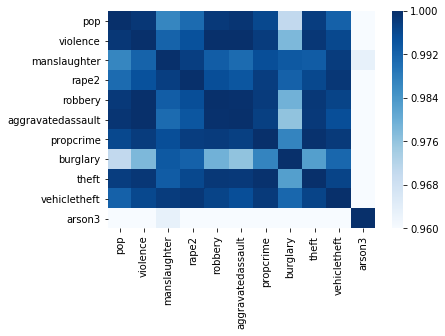

,pop,violence,manslaughter,rape2,robbery,aggravatedassault,propcrime,burglary,theft,vehicletheft,arson3
pop,1.000000,0.998854,0.986758,0.990839,0.998469,0.999134,0.996265,0.970578,0.997946,0.992421,0.701761
violence,0.998854,1.000000,0.992098,0.994985,0.999923,0.999942,0.998059,0.978150,0.998762,0.996271,0.917793
manslaughter,0.986758,0.992098,1.000000,0.997746,0.993104,0.990843,0.995403,0.993733,0.993175,0.997992,0.963200
rape2,0.990839,0.994985,0.997746,1.000000,0.995438,0.994140,0.997843,0.992442,0.996260,0.998764,0.926301
robbery,0.998469,0.999923,0.993104,0.995438,1.000000,0.999742,0.998237,0.979525,0.998735,0.996927,0.931607
aggravatedassault,0.999134,0.999942,0.990843,0.994140,0.999742,1.000000,0.997622,0.976288,0.998561,0.995403,0.888278
propcrime,0.996265,0.998059,0.995403,0.997843,0.998237,0.997622,1.000000,0.987137,0.999666,0.998302,0.920765
burglary,0.970578,0.978150,0.993733,0.992442,0.979525,0.976288,0.987137,1.000000,0.982700,0.991464,0.952121
theft,0.997946,0.998762,0.993175,0.996260,0.998735,0.998561,0.999666,0.982700,1.000000,0.996878,0.893610
vehicletheft,0.992421,0.996271,0.997992,0.998764,0.996927,0.995403,0.998302,0.991464,0.996878,1.000000,0.935194


In [21]:
sns.heatmap(crime.corr(),cmap='Blues',vmax=1,vmin=.96)
plt.show()
crime.corr()

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

In [30]:
crime = crime.loc[crime['pop'].notnull()]
crime = crime.loc[crime['propcrime'].notnull()]
crime = crime.loc[crime['manslaughter'].notnull()]
crime = crime.loc[crime['pop'].isnull() == False]

In [31]:
features = pd.DataFrame()

In [32]:
features['propcrime'] = crime.propcrime
features['pop'] = crime['pop']
features['pop2'] = np.power(crime['pop'],2)
features['rape2'] = crime['rape2'].apply(lambda val: 1 if val > 0 else 0)
features['theft'] = crime['theft'].apply(lambda val: 1 if val > 0 else 0)
features['burglary'] = crime['burglary'].apply(lambda val: 1 if val > 0 else 0)

In [75]:
# Sample data to play with.
y = features['propcrime'].values.reshape(-1, 1)
X = features[['pop','pop2','rape2','theft','burglary']]

print(np.shape(y))
print(np.shape(X))

(348, 1)
(348, 5)


_Why squaring population? Why don't we use one feature? What does reshape(-1,1) do?_

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

In [77]:
# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

Coefficients: 
 [[ 3.59150239e-02 -2.26044823e-09 -6.72869061e+01 -2.84268928e+01
  -1.00200737e+02]]
Intercept: 
 [-27.65805391]


In [79]:
regr.score(X_test,y_test)

0.33938374773607444

In [80]:
# Extract predicted values.
predicted = regr.predict(X_test).ravel().reshape(70,1)
actual = y_test

# Calculate the error, also called the residual.
residual = actual - predicted

print(len(predicted),len(actual),len(residual))
np.shape(predicted)

70 70 70


(70, 1)

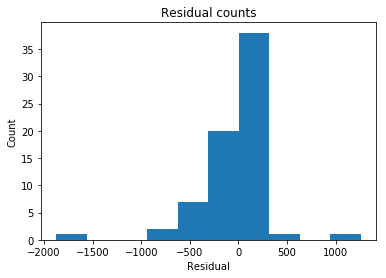

In [81]:
# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

_No normal distribution_

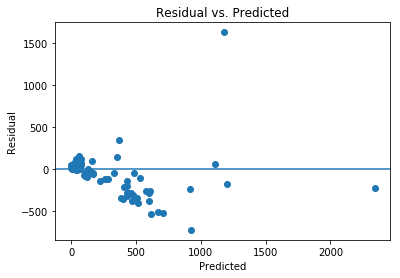

In [65]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

_Definitely not normally distributed. Has outliers and negative linear trend_

In [40]:
correlation_matrix = X.corr()
display(correlation_matrix)

,pop,pop2,rape2,theft,burglary
pop,1.000000,0.998264,0.087335,0.012352,0.021693
pop2,0.998264,1.000000,0.064167,0.007729,0.013670
rape2,0.087335,0.064167,1.000000,0.120375,0.212913
theft,0.012352,0.007729,0.120375,1.000000,0.479420
burglary,0.021693,0.013670,0.212913,0.479420,1.000000
